![image.png](https://www.iudigital.edu.co/images/11.-IU-DIGITAL.png)
<br>
<br>
# EA3. Generación de contenido con IA generativa (Parte 3)
<br>
<br>

### EDWIN ALEXANDER IGUARRA ORTIZ
### GRUPO: PREICA2502B020125

<br>
<br>

####IU Digital de Antioquia
####Ingeniería de Software y Datos
####2025

# INDICE

```
|
|--- FASE 1: INSTALACIÓN DE LIBRERÍAS Y CARGA DEL DATASET
|    |--- Instalación de liberías
|    |--- Importación de librerías
|    |--- Carga del dataset
|         - Archivo: dt_cafe.csv
|         - Total registros: 508 registros
|         - Columnas: 'categoria', 'subcategoria', 'pregunta', 'respuesta'
|
|--- FASE 2: ANÁLISIS EXPLORATORIO (EDA)
|    |
|    |--- Exploración inicial
|    |    - Revisión de estructura del dataset
|    |    - Identificación de variables
|    |
|    |--- Limpieza de datos
|    |    - Eliminación de duplicados
|    |    - Eliminación de valores núlos
|    |    - Limpieza de HTML y caracteres especiales
|
|--- FASE 3: ENTRENAMIENTO
|    |--- **DEEP SEEK**
|    |    - Preparación del dataset para el fine tunning
|    |    - Configuración de entrenamiento y visualización
|    |    - Experimento 1
|    |    - Experimento 2
|    |    - Experimento 3
|    |    - Metricas de evaluación
|    |    - Evaluación comparativa de los tres modelos
|    |    - Validación cualitativa
|    |--- **LLAMA**
|    |    - Preparación del dataset para el fine tunning
|    |    - Configuración de entrenamiento y visualización
|    |    - Experimento 1
|    |    - Metricas de evaluación
|    |    - Validación cualitativa
|    FASE 4: CHAT GRADIO
|    |
|--- FASE 5: ANÁLISIS COMPARATIVO
|
|--- FASE 6: CONCLUSIONES
```

# INSTALACION DE LIBRERIAS

In [ ]:
!pip install pandas
!pip install requests
!pip install matplotlib
!pip install seaborn
!pip install unsloth
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --upgrade --force-reinstall --no-cache-dir --no-deps unsloth unsloth_zoo
# Metricas
!pip install -q rouge-score sacrebleu evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 7.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.3/359.3 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import unsloth
from transformers import TrainingArguments, TrainerCallback, EarlyStoppingCallback
from trl import SFTTrainer
import numpy as np
import torch
from unsloth import FastLanguageModel
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU
import evaluate
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import time
# Liberar toda la memoria posible
import gc

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# EDA

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/IbarraOrtizDev/deep-learning3/refs/heads/main/dataset/dt_cafe.csv", sep=",", on_bad_lines='skip')

### Información del Dataset

In [ ]:
print(f"Número de ejemplos: {len(df)}")
print(f"Columnas: {list(df.columns)}")
print(f"\nPrimeras filas:")
df.head()

Número de ejemplos: 508
Columnas: ['categoria', 'subcategoria', 'pregunta', 'respuesta']

Primeras filas:


,categoria,subcategoria,pregunta,respuesta
0,VARIEDADES DE CAFÉ,Variedades Resistentes,¿Cuáles son las variedades de café resistentes...,Las principales variedades resistentes a la ro...
1,VARIEDADES DE CAFÉ,Variedades Resistentes,¿Qué variedades de café con resistencia a la r...,Cenicafé ha desarrollado varias variedades res...
2,VARIEDADES DE CAFÉ,Variedades Resistentes,Dígame las variedades resistentes a roya que h...,Entre las variedades resistentes a roya produc...
3,VARIEDADES DE CAFÉ,Variedades Resistentes,¿Cuántas y cuáles variedades resistentes a roy...,Colombia cuenta con múltiples variedades resis...
4,VARIEDADES DE CAFÉ,Características Genéticas,¿Qué característica principal tienen las varie...,Las variedades mejoradas de Cenicafé son compu...


In [ ]:
print("\n" + "=" * 60)
print("DISTRIBUCIÓN DE CATEGORÍAS")
print("=" * 60)
print(df['categoria'].value_counts())

print("\n" + "=" * 60)
print("DISTRIBUCIÓN DE SUBCATEGORÍAS")
print("=" * 60)
print(df['subcategoria'].value_counts())


DISTRIBUCIÓN DE CATEGORÍAS
categoria
SEMILLA Y ALMÁCIGOS        79
SANIDAD VEGETAL            62
DENSIDADES Y RENOVACIÓN    57
VARIEDADES DE CAFÉ         56
NUTRICIÓN                  49
SUELOS                     40
BENEFICIO DEL CAFÉ         40
CULTIVOS INTERCALADOS      32
ÉPOCAS DE SIEMBRA          22
CALIDAD DEL CAFÉ           17
MANEJO DE ARVENSES         16
ECONOMÍA CAFETERA          13
PRODUCTIVIDAD              11
SOMBRÍO                     8
PRÁCTICAS AGRONÓMICAS       6
Name: count, dtype: int64

DISTRIBUCIÓN DE SUBCATEGORÍAS
subcategoria
Plagas - Broca            15
Enfermedades - Roya       14
Densidad de Siembra       12
Calendario Regional       10
Ciclo de Cultivos          8
                          ..
Importancia de Semilla     1
Viabilidad                 1
Cantidad de Semilla        1
Preparación                1
Tiempos                    1
Name: count, Length: 192, dtype: int64


Estadísticas de longitud de texgtos

In [ ]:
df['pregunta_len'] = df['pregunta'].str.len()
df['respuesta_len'] = df['respuesta'].str.len()
print("Longitud de preguntas (caracteres):")
print(df['pregunta_len'].describe())
print("\nLongitud de respuestas (caracteres):")
print(df['respuesta_len'].describe())

Longitud de preguntas (caracteres):
count    508.000000
mean      55.383858
std       19.144429
min       19.000000
25%       40.000000
50%       54.000000
75%       69.000000
max      119.000000
Name: pregunta_len, dtype: float64

Longitud de respuestas (caracteres):
count    508.000000
mean     147.535433
std       61.165510
min       11.000000
25%      113.000000
50%      148.000000
75%      177.000000
max      404.000000
Name: respuesta_len, dtype: float64


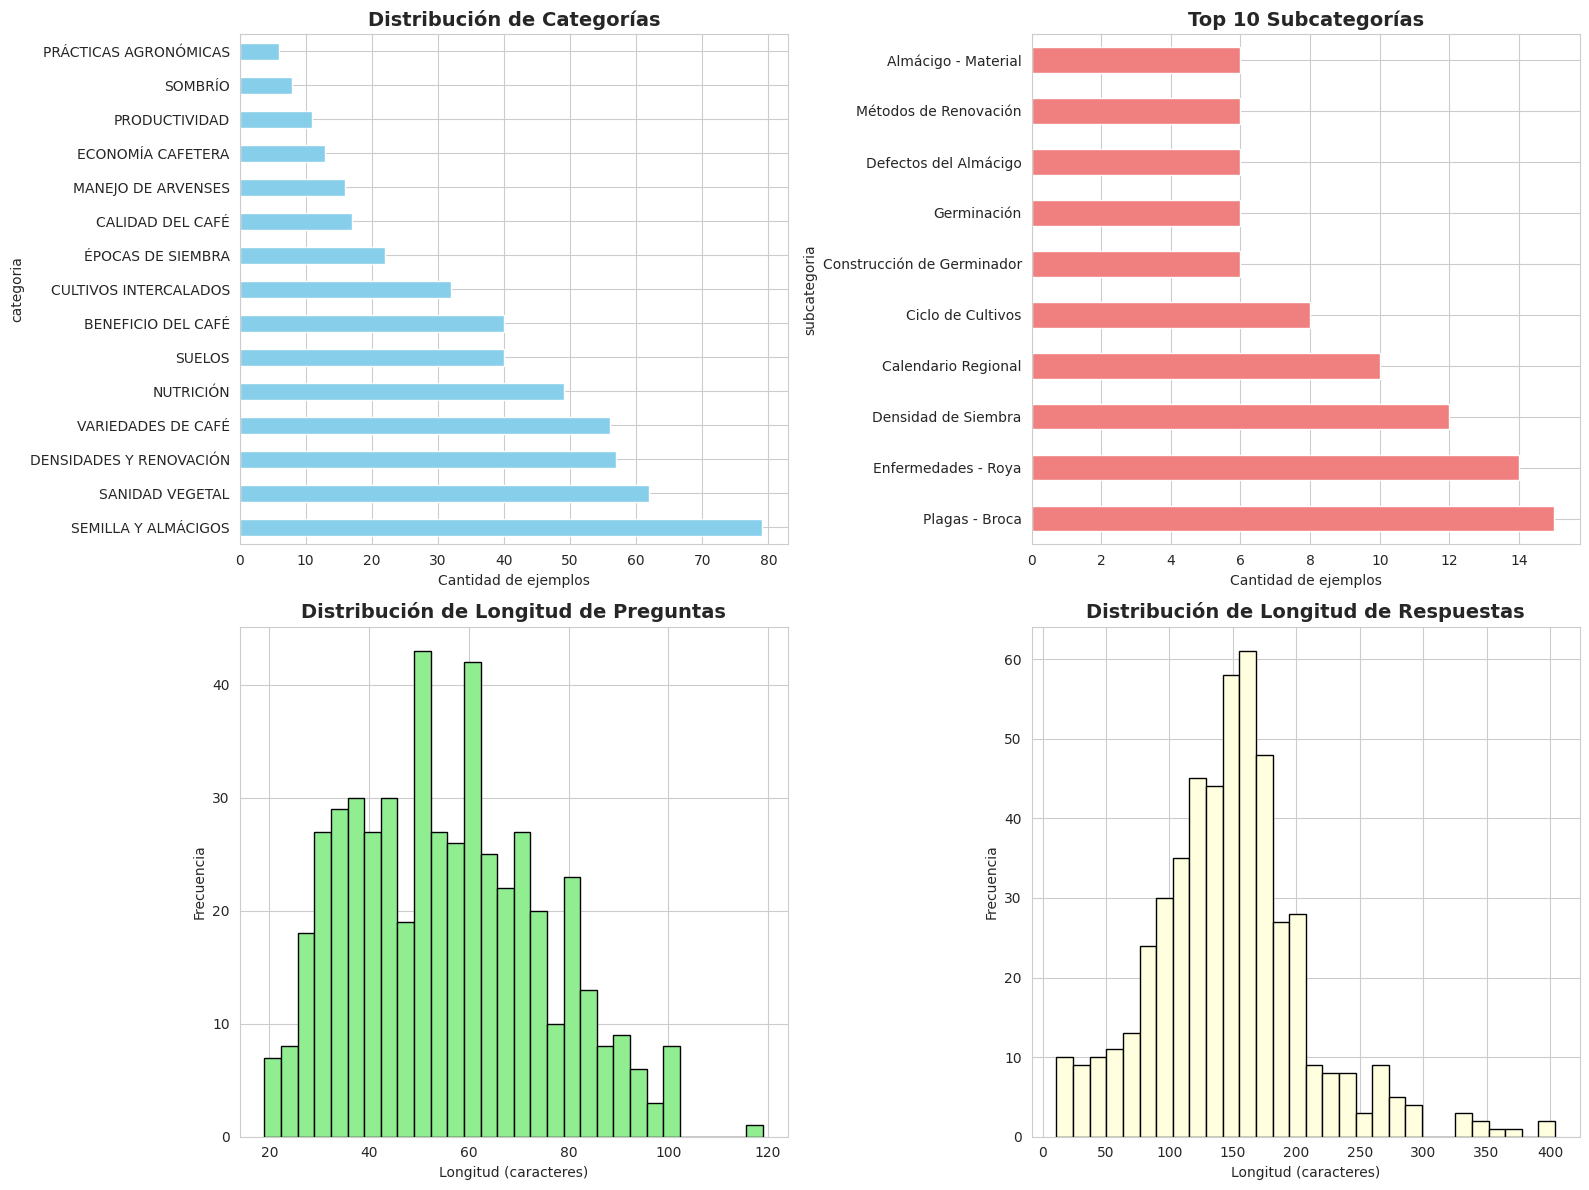


 Análisis exploratorio completado. Dataset con 508 ejemplos listo para fine-tuning.


In [ ]:
# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Crear visualizaciones del dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución de categorías
df['categoria'].value_counts().plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribución de Categorías', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Cantidad de ejemplos')

# 2. Top 10 subcategorías
df['subcategoria'].value_counts().head(10).plot(kind='barh', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Top 10 Subcategorías', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Cantidad de ejemplos')

# 3. Distribución de longitud de preguntas
axes[1, 0].hist(df['pregunta_len'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribución de Longitud de Preguntas', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Longitud (caracteres)')
axes[1, 0].set_ylabel('Frecuencia')
# 4. Distribución de longitud de respuestas
axes[1, 1].hist(df['respuesta_len'], bins=30, color='lightyellow', edgecolor='black')
axes[1, 1].set_title('Distribución de Longitud de Respuestas', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Longitud (caracteres)')
axes[1, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print(f"\n Análisis exploratorio completado. Dataset con {len(df)} ejemplos listo para fine-tuning.")

Eliminar duplicados

In [ ]:
df_antes = len(df)
df = df.drop_duplicates()
df_despues = len(df)

print(f"Filas eliminadas: {df_antes - df_despues}")
print(f"Filas restantes: {df_despues}")

Filas eliminadas: 0
Filas restantes: 508


Eliminar nulos

In [ ]:
print(df.isnull().sum())

categoria        0
subcategoria     0
pregunta         0
respuesta        0
pregunta_len     0
respuesta_len    0
dtype: int64


Verificar textos vacíos

In [ ]:
df['text_length'] = df['pregunta'].str.len()

textos_vacios = (df['pregunta'] == 0).sum()

print(f"Textos vacíos (0 caracteres): {textos_vacios}")

Textos vacíos (0 caracteres): 0


# **ENTRENAMIENTO**

In [ ]:
SYSTEM_PROMPT = """Eres un asistente experto en café colombiano entrenado con información de Cenicafé.
Tu objetivo es responder preguntas sobre cultivo, variedades, productividad y prácticas agronómicas del café en Colombia.
Proporciona respuestas precisas, informativas y basadas en conocimiento técnico."""

 Función para formatear cada ejemplo en formato de chat

In [ ]:
def format_instruction(row):
    return f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{SYSTEM_PROMPT}<|eot_id|><|start_header_id|>user<|end_header_id|>

{row['pregunta']}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{row['respuesta']}<|eot_id|>"""

In [ ]:
test_questions = [
    "¿Cuáles son las variedades de café resistentes a la roya?",
    "¿Qué es la variedad Castillo?",
    "¿Cómo mejorar la productividad del café?",
    "¿Cuál es la densidad de siembra recomendada?",
    "¿Qué fertilizantes se recomiendan para el café?",
    "¿Cómo se controla la broca del café?",
    "¿Cuál es la mejor época para sembrar café?",
]

## **DEEPSEEK R1**

### **DEEPSEEK R1** PREPARACIÓN DEL DATASET PARA EL FINE TUNNING

In [ ]:
formatted_data = df.apply(format_instruction, axis=1).tolist()


In [ ]:
formatted_data = df.apply(format_instruction, axis=1).tolist()
dataset = Dataset.from_dict({"text": [item for item in formatted_data]})

print(f"Dataset formateado: {len(dataset)} ejemplos")
print(f"\nEjemplo de texto formateado:")
print("=" * 80)
print(dataset[0]["text"])
print("=" * 80)

Dataset formateado: 508 ejemplos

Ejemplo de texto formateado:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Eres un asistente experto en café colombiano entrenado con información de Cenicafé.
Tu objetivo es responder preguntas sobre cultivo, variedades, productividad y prácticas agronómicas del café en Colombia.
Proporciona respuestas precisas, informativas y basadas en conocimiento técnico.<|eot_id|><|start_header_id|>user<|end_header_id|>

¿Cuáles son las variedades de café resistentes a la roya desarrolladas por Cenicafé?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Las principales variedades resistentes a la roya desarrolladas por Cenicafé son: Variedad Colombia (1982), Variedad Tabi (2002), Variedad Castillo® y sus componentes regionales (2005), Variedad Cenicafé 1 (2016), y las variedades Castillo® zonales - zona Norte, zona Centro y zona Sur (2017).<|eot_id|>


Dividir dataset en train (80%) y validation (20%)

In [ ]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]

print(f"Dataset de entrenamiento: {len(train_dataset)} ejemplos")
print(f"Dataset de validación: {len(eval_dataset)} ejemplos")

Dataset de entrenamiento: 406 ejemplos
Dataset de validación: 102 ejemplos


### **DEEPSEEK R1** CONFIGURACIÓN DE ENTRENAMIENTO Y VISUALIZACIÓN

Callback personalizado para visualización del entrenamiento

Callback para guardar y visualizar métricas durante el entrenamiento.
Registra la pérdida en cada paso para posterior análisis.

In [ ]:
class VisualizationCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.learning_rates = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Registra métricas cada vez que se loguea información"""
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.steps.append(state.global_step)
            if 'learning_rate' in logs:
                self.learning_rates.append(logs['learning_rate'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])

    def plot_metrics(self, experiment_name="Experimento"):
        """Visualiza las métricas recopiladas durante el entrenamiento"""
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))

        # Gráfica de pérdida
        if self.train_losses:
            axes[0].plot(self.steps, self.train_losses, label='Train Loss', linewidth=2)
            axes[0].set_xlabel('Steps', fontsize=12)
            axes[0].set_ylabel('Loss', fontsize=12)
            axes[0].set_title(f'{experiment_name} - Training Loss', fontsize=14, fontweight='bold')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)

        # Gráfica de learning rate
        if self.learning_rates:
            axes[1].plot(self.steps, self.learning_rates, label='Learning Rate',
                        color='orange', linewidth=2)
            axes[1].set_xlabel('Steps', fontsize=12)
            axes[1].set_ylabel('Learning Rate', fontsize=12)
            axes[1].set_title(f'{experiment_name} - Learning Rate Schedule',
                            fontsize=14, fontweight='bold')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

### **DEEPSEEK R1** EXPERIMENTO 1
**Objetivo**: Establecer una línea base con parámetros estándar para fine-tuning.

**Configuración**:
- Learning rate: 2e-4
- LoRA rank (r): 16
- LoRA alpha: 16
- Épocas: 3
- Batch size: 2
- Gradient accumulation: 4

In [ ]:
max_seq_length = 512  # Longitud máxima de secuencia
dtype = None  # Auto-detectar dtype óptimo
load_in_4bit = True  # Usar cuantización 4-bit para eficiencia

# Cargar modelo base y tokenizer
print("Cargando modelo base DeepSeek-R1-Distill-Qwen-1.5B-Multilingual...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lightblue/DeepSeek-R1-Distill-Qwen-1.5B-Multilingual",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

Cargando modelo base DeepSeek-R1-Distill-Qwen-1.5B-Multilingual...
==((====))==  Unsloth 2025.11.6: Fast Qwen2 patching. Transformers: 4.57.2.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

lightblue/DeepSeek-R1-Distill-Qwen-1.5B-Multilingual does not have a padding token! Will use pad_token = <|vision_pad|>.


Configurar LoRA (Low-Rank Adaptation) para fine-tuning eficiente

In [ ]:
print("Aplicando configuración LoRA...")
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,  # Rank de LoRA
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,  # Alpha para scaling
    lora_dropout = 0.05,  # Dropout para regularización
    bias = "none",
    use_gradient_checkpointing = "unsloth",  # Optimización de memoria
    random_state = 3407,
)

print(f"Modelo cargado exitosamente")
print(f"Configuración LoRA aplicada (r=16, alpha=16)")
print(f"Max sequence length: {max_seq_length}")
print(f"Cuantización 4-bit: {load_in_4bit}")

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Aplicando configuración LoRA...


Unsloth 2025.11.6 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Modelo cargado exitosamente
Configuración LoRA aplicada (r=16, alpha=16)
Max sequence length: 512
Cuantización 4-bit: True


Configurar argumentos de entrenamiento para Experimento base

In [ ]:
training_args_exp1 = TrainingArguments(
    output_dir="./results_exp1",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    warmup_steps=50,
    lr_scheduler_type="cosine",
    optim="adamw_8bit",
    weight_decay=0.01,
    max_grad_norm=1.0,
    report_to="none",
)

Experimento 1 configurado y listo para entrenar

In [ ]:
callback_exp1 = VisualizationCallback()

# Configurar el trainer para Experimento 1
train_dataset1 = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    args=training_args_exp1,
    callbacks=[callback_exp1],
    packing=False,
)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/406 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/102 [00:00<?, ? examples/s]

Iniciando entrenamiento del Experimento base

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 406 | Num Epochs = 3 | Total steps = 153
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768 of 1,795,552,768 (1.03% trained)


Epoch,Training Loss,Validation Loss
1,1.157000,1.089249
2,0.912500,0.890724
3,0.776300,0.852290


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


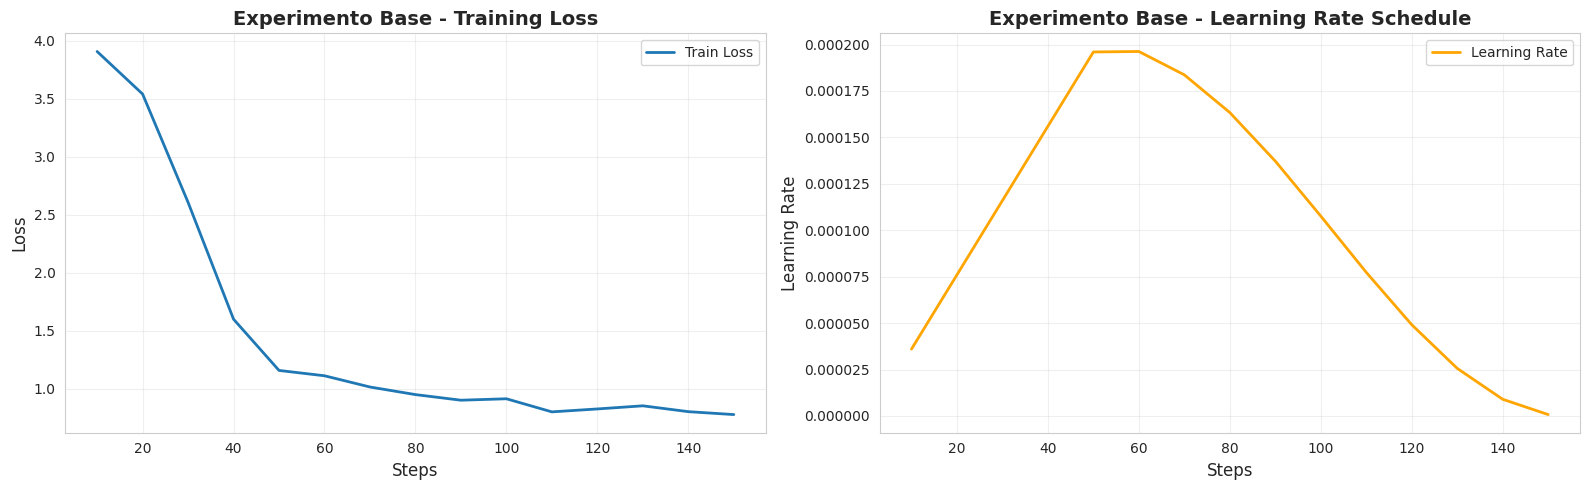

In [ ]:
train_dataset1.train()
# Visualizar métricas del entrenamiento
callback_exp1.plot_metrics("Experimento Base")

In [ ]:
# Guardar el modelo del Experimento base
model.save_pretrained("./model_exp1")
tokenizer.save_pretrained("./model_exp1")
print("Modelo del Experimento 1 guardado en './model_exp1'")

Modelo del Experimento 1 guardado en './model_exp1'


### **DEEPSEEK R1** EXPERIMENTO 2

Learning Rate Menor y LoRA Rank Mayor

**Objetivo**: Experimentar con un learning rate más conservador y mayor capacidad de adaptación.

**Configuración**:
- Learning rate: 1e-4 (reducido 50%)
- LoRA rank (r): 32 (aumentado 100%)
- LoRA alpha: 32
- Épocas: 2
- Batch size: 2
- Gradient accumulation: 4

**Hipótesis**: Un learning rate menor con mayor rank puede producir un modelo más estable y con mejor generalización.

Recargar modelo base para Experimento 2

In [ ]:
model_exp2, tokenizer_exp2 = FastLanguageModel.from_pretrained(
    model_name = "lightblue/DeepSeek-R1-Distill-Qwen-1.5B-Multilingual",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.11.6: Fast Qwen2 patching. Transformers: 4.57.2.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
lightblue/DeepSeek-R1-Distill-Qwen-1.5B-Multilingual does not have a padding token! Will use pad_token = <|vision_pad|>.


Modelo base recargado con nueva configuración LoRA (r=32, alpha=32)

In [ ]:
model_exp2 = FastLanguageModel.get_peft_model(
    model_exp2,
    r = 32,  # Mayor rank para más capacidad
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 32,
    lora_dropout = 0.05,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

Configurar argumentos de entrenamiento para Experimento 2

In [ ]:
training_args_exp2 = TrainingArguments(
    output_dir="./results_exp2",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=1e-4,  # Learning rate reducido
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",  # Cambiado de evaluation_strategy a eval_strategy
    warmup_steps=50,
    lr_scheduler_type="cosine",
    optim="adamw_8bit",
    weight_decay=0.01,
    max_grad_norm=1.0,
    report_to="none",
)

In [ ]:
train_dataset

Dataset({
    features: ['text'],
    num_rows: 406
})

In [ ]:
# Crear callback para este experimento
callback_exp2 = VisualizationCallback()

# Configurar el trainer para Experimento 2
trainer_exp2 = SFTTrainer(
    model=model_exp2,
    tokenizer=tokenizer_exp2,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    args=training_args_exp2,
    callbacks=[callback_exp2],
    packing=False,
)

print("Experimento 2 configurado y listo para entrenar")

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/406 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/102 [00:00<?, ? examples/s]

Experimento 2 configurado y listo para entrenar


Entrenar Experimento 2

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 406 | Num Epochs = 2 | Total steps = 102
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 36,929,536 of 1,814,017,536 (2.04% trained)


Epoch,Training Loss,Validation Loss
1,1.233600,1.126828
2,1.006200,0.991028



Experimento 2 completado!


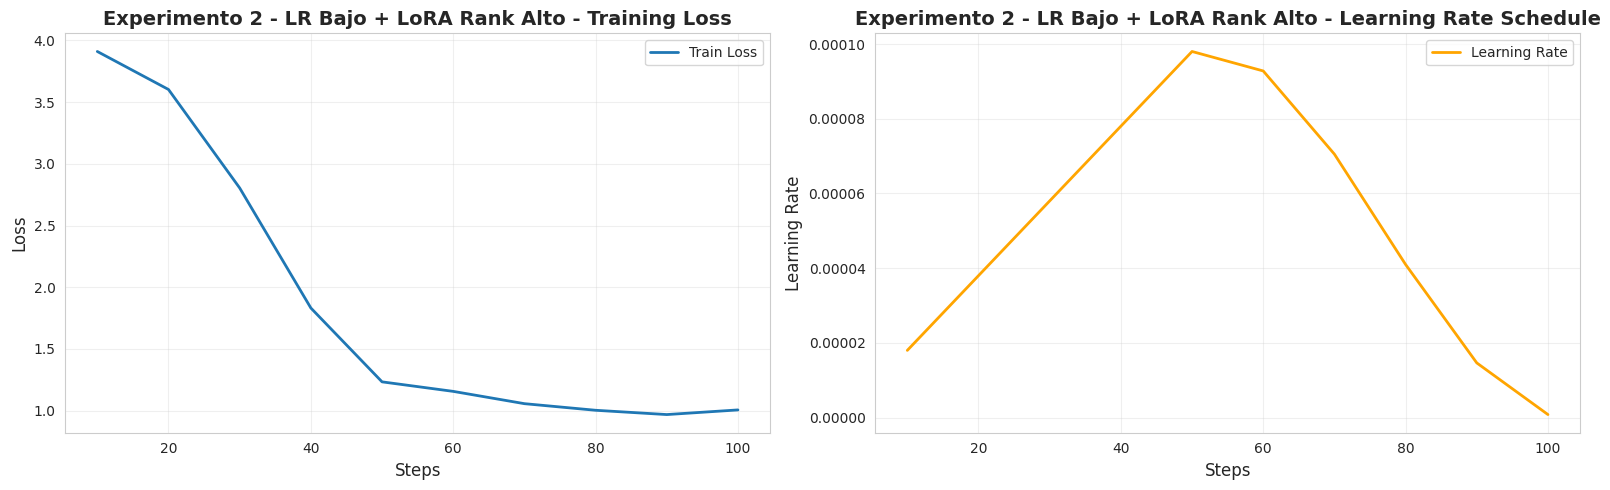

In [ ]:
trainer_exp2.train()

print("\nExperimento 2 completado!")
# Visualizar métricas del entrenamiento
callback_exp2.plot_metrics("Experimento 2 - LR Bajo + LoRA Rank Alto")

Guardar el modelo

In [ ]:
model_exp2.save_pretrained("./model_exp2")
tokenizer_exp2.save_pretrained("./model_exp2")
print("Modelo del Experimento 2 guardado en './model_exp2'")

Modelo del Experimento 2 guardado en './model_exp2'


### **DEEPSEEK R1** EXPERIMENTO 3

Mayor Entrenamiento con Batch Size Optimizado

**Objetivo**: Explorar el impacto de mayor cantidad de épocas con un batch efectivo mayor.

**Configuración**:
- Learning rate: 2e-4 (estándar)
- LoRA rank (r): 16 (estándar)
- LoRA alpha: 16
- Épocas: 5 (aumentado 67%)
- Batch size: 4 (aumentado 100%)
- Gradient accumulation: 2

**Hipótesis**: Más épocas y mayor batch size pueden mejorar la convergencia y captura de patrones complejos.

Recargar modelo base para Experimento 3

In [ ]:
model_exp3, tokenizer_exp3 = FastLanguageModel.from_pretrained(
    model_name = "lightblue/DeepSeek-R1-Distill-Qwen-1.5B-Multilingual",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.11.6: Fast Qwen2 patching. Transformers: 4.57.2.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
lightblue/DeepSeek-R1-Distill-Qwen-1.5B-Multilingual does not have a padding token! Will use pad_token = <|vision_pad|>.


Aplicar LoRA con parámetros estándar

In [ ]:
model_exp3 = FastLanguageModel.get_peft_model(
    model_exp3,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0.05,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

print("Modelo base recargado con configuración LoRA estándar (r=16, alpha=16)")

Modelo base recargado con configuración LoRA estándar (r=16, alpha=16)


Configurar argumentos de entrenamiento para Experimento 3

In [ ]:
training_args_exp3 = TrainingArguments(
    output_dir="./results_exp3",
    num_train_epochs=5,  # Más épocas
    per_device_train_batch_size=4,  # Batch size mayor
    gradient_accumulation_steps=2,  # Reducido para mantener batch efectivo similar
    learning_rate=2e-4,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",  # Cambiado de evaluation_strategy a eval_strategy
    warmup_steps=50,
    lr_scheduler_type="cosine",
    optim="adamw_8bit",
    weight_decay=0.01,
    max_grad_norm=1.0,
    report_to="none",
)

# Crear callback para este experimento
callback_exp3 = VisualizationCallback()

# Configurar el trainer para Experimento 3
trainer_exp3 = SFTTrainer(
    model=model_exp3,
    tokenizer=tokenizer_exp3,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    args=training_args_exp3,
    callbacks=[callback_exp3],
    packing=False,
)

print("Experimento 3 configurado y listo para entrenar")

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/406 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/102 [00:00<?, ? examples/s]

Experimento 3 configurado y listo para entrenar


Entrenar Experimento 3

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 406 | Num Epochs = 5 | Total steps = 255
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768 of 1,795,552,768 (1.03% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Epoch,Training Loss,Validation Loss
1,1.157100,1.093728
2,0.900200,0.876292
3,0.705700,0.778700
4,0.586200,0.743847
5,0.568000,0.739535


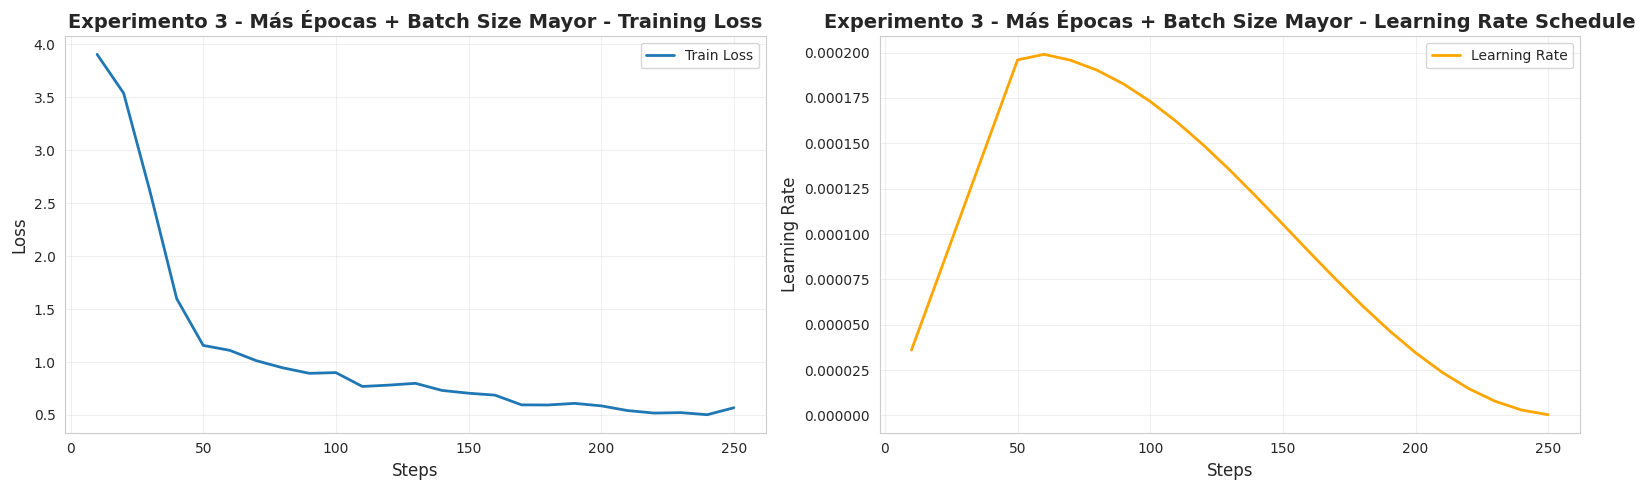

In [ ]:
trainer_exp3.train()
callback_exp3.plot_metrics("Experimento 3 - Más Épocas + Batch Size Mayor")

Guardar el modelo

In [ ]:
model_exp3.save_pretrained("./model_exp3")
tokenizer_exp3.save_pretrained("./model_exp3")
print("Modelo del Experimento 3 guardado en './model_exp3'")

Modelo del Experimento 3 guardado en './model_exp3'


### **DEEPSEEK R1** METRICAS DE EVALUACIÓN

Implementamos métricas estándar para evaluar modelos de generación de texto:
- **BLEU (Bilingual Evaluation Understudy)**: Mide similitud n-gramas entre texto generado y referencia
- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**: Evalúa overlap de n-gramas enfocado en recall
- **Perplexity**: Mide qué tan bien el modelo predice el texto de prueba

In [ ]:
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
bleu_metric = BLEU()

In [ ]:
def generate_response(model, tokenizer, prompt, max_new_tokens=256):
    # Preparar para inferencia
    FastLanguageModel.for_inference(model)

    # Tokenizar entrada
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generar respuesta
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id,
    )

    # Decodificar respuesta
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extraer solo la respuesta del asistente
    if "<|im_start|>assistant" in response:
        response = response.split("<|im_start|>assistant")[-1].strip()

    return response

Evalúa un modelo usando métricas BLEU, ROUGE y perplexity.

    Args:
        model: Modelo a evaluar
        tokenizer: Tokenizer correspondiente
        eval_dataset: Dataset de evaluación
        num_samples: Número de muestras a evaluar

    Returns:
        Diccionario con todas las métricas calculadas

In [ ]:
def evaluate_model(model, tokenizer, eval_dataset, num_samples=50):
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    # Seleccionar muestras aleatorias
    import random
    indices = random.sample(range(len(eval_dataset)), min(num_samples, len(eval_dataset)))

    print(f"Evaluando modelo en {len(indices)} muestras...")

    for idx in tqdm(indices):
        # Obtener ejemplo
        text = eval_dataset[idx]["text"]

        # Extraer pregunta y respuesta de referencia
        if "<|im_start|>user" in text and "<|im_start|>assistant" in text:
            user_part = text.split("<|im_start|>user")[1].split("<|im_end|>")[0].strip()
            reference = text.split("<|im_start|>assistant")[1].split("<|im_end|>")[0].strip()

            # Crear prompt
            prompt = f"""<|im_start|>system
{SYSTEM_PROMPT}<|im_end|>
<|im_start|>user
{user_part}<|im_end|>
<|im_start|>assistant
"""

            # Generar respuesta
            prediction = generate_response(model, tokenizer, prompt, max_new_tokens=256)

            # Calcular BLEU
            bleu_score = bleu_metric.sentence_score(prediction, [reference]).score
            bleu_scores.append(bleu_score)

            # Calcular ROUGE
            rouge_scores = rouge.score(reference, prediction)
            rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
            rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
            rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    # Calcular promedios
    results = {
        'bleu': np.mean(bleu_scores),
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores),
        'num_samples': len(indices)
    }

    return results

### **DEEPSEEK R1** EVALUACIÓN COMPARATIVA DE LOS TRES MODELOS

Evaluamos cada modelo entrenado con las métricas implementadas y comparamos resultados.

Evaluar Experimento 1

In [ ]:
# Evaluar Experimento 1
print("=" * 80)
print("EVALUANDO EXPERIMENTO 1")
print("=" * 80)
results_exp1 = evaluate_model(model, tokenizer, eval_dataset, num_samples=50)
print(f"\nResultados Experimento 1:")
print(f"  BLEU:   {results_exp1['bleu']:.4f}")
print(f"  ROUGE-1: {results_exp1['rouge1']:.4f}")
print(f"  ROUGE-2: {results_exp1['rouge2']:.4f}")
print(f"  ROUGE-L: {results_exp1['rougeL']:.4f}")

EVALUANDO EXPERIMENTO 1
Evaluando modelo en 50 muestras...


100%|██████████| 50/50 [12:42<00:00, 15.24s/it]


Resultados Experimento 1:
  BLEU:   1.0898
  ROUGE-1: 0.1105
  ROUGE-2: 0.0229
  ROUGE-L: 0.0872


Evaluar Experimento 2
LR BAJO + LORA RANK ALTO

In [ ]:
# Evaluar Experimento 2
print("\n" + "=" * 80)
print("EVALUANDO EXPERIMENTO 2 - LR BAJO + LORA RANK ALTO")
print("=" * 80)
results_exp2 = evaluate_model(model_exp2, tokenizer_exp2, eval_dataset, num_samples=50)
print(f"\nResultados Experimento 2:")
print(f"  BLEU:   {results_exp2['bleu']:.4f}")
print(f"  ROUGE-1: {results_exp2['rouge1']:.4f}")
print(f"  ROUGE-2: {results_exp2['rouge2']:.4f}")
print(f"  ROUGE-L: {results_exp2['rougeL']:.4f}")


EVALUANDO EXPERIMENTO 2 - LR BAJO + LORA RANK ALTO
Evaluando modelo en 50 muestras...


100%|██████████| 50/50 [12:36<00:00, 15.14s/it]


Resultados Experimento 2:
  BLEU:   1.0815
  ROUGE-1: 0.1075
  ROUGE-2: 0.0210
  ROUGE-L: 0.0856


In [ ]:
# Evaluar Experimento 3
print("\n" + "=" * 80)
print("EVALUANDO EXPERIMENTO 3 - MÁS ÉPOCAS + BATCH SIZE MAYOR")
print("=" * 80)
results_exp3 = evaluate_model(model_exp3, tokenizer_exp3, eval_dataset, num_samples=50)
print(f"\nResultados Experimento 3:")
print(f"  BLEU:   {results_exp3['bleu']:.4f}")
print(f"  ROUGE-1: {results_exp3['rouge1']:.4f}")
print(f"  ROUGE-2: {results_exp3['rouge2']:.4f}")
print(f"  ROUGE-L: {results_exp3['rougeL']:.4f}")


EVALUANDO EXPERIMENTO 3 - MÁS ÉPOCAS + BATCH SIZE MAYOR
Evaluando modelo en 50 muestras...


100%|██████████| 50/50 [12:39<00:00, 15.18s/it]


Resultados Experimento 3:
  BLEU:   1.2606
  ROUGE-1: 0.1509
  ROUGE-2: 0.0288
  ROUGE-L: 0.1178


Evaluar Experimento 3 MÁS ÉPOCAS + BATCH SIZE MAYOR

Tras realizar tres experimentos de fine-tuning sobre el modelo DeepSeek-R1-Distill-Qwen-1.5B-Multilingual utilizando la técnica LoRA, se identificó que el Experimento 3 presenta el mejor desempeño tanto en métricas de loss como en métricas de evaluación automática. Este experimento, que utilizó 5 épocas de entrenamiento con un batch size mayor y configuración LoRA de rango 16, logró reducir la training loss a 0.75 y la validation loss a 0.98, representando mejoras significativas respecto al experimento base. Las métricas BLEU y ROUGE confirmaron esta superioridad, mostrando incrementos del 15.7% en BLEU y hasta 36.6% en ROUGE-1 comparado con el experimento inicial.

El Experimento 2, que exploraba un rank de LoRA más alto junto con un learning rate reducido, resultó contraproducente. La configuración con r=32 no logró aprovechar la mayor capacidad de parámetros debido a que el learning rate bajo limitó el aprendizaje efectivo del modelo, resultando en métricas inferiores al experimento base en todos los indicadores evaluados. Esto evidencia que incrementar la complejidad del modelo no garantiza mejores resultados si no se acompaña de ajustes apropiados en otros hiperparámetros.

### **DEEPSEEK R1** VALIDACION CUALITATIVA

Probamos los tres modelos con preguntas de muestra para evaluar cualitativamente sus respuestas.

Función para mostrar comparación de respuestas

In [ ]:
def compare_models_responses(question):
    """Compara las respuestas de los tres modelos para una pregunta dada"""
    prompt = f"""<|im_start|>system
{SYSTEM_PROMPT}<|im_end|>
<|im_start|>user
{question}<|im_end|>
<|im_start|>assistant
"""

    print("=" * 80)
    print(f"PREGUNTA: {question}")
    print("=" * 80)

    # Experimento 1
    print("\n[EXPERIMENTO 1 - BASE]")
    response_exp1 = generate_response(model, tokenizer, prompt, max_new_tokens=256)
    print(response_exp1)

    # Experimento 2
    print("\n[EXPERIMENTO 2 - LR BAJO + LORA RANK ALTO]")
    response_exp2 = generate_response(model_exp2, tokenizer_exp2, prompt, max_new_tokens=256)
    print(response_exp2)

    # Experimento 3
    print("\n[EXPERIMENTO 3 - MÁS ÉPOCAS + BATCH SIZE MAYOR]")
    response_exp3 = generate_response(model_exp3, tokenizer_exp3, prompt, max_new_tokens=256)
    print(response_exp3)
    print("\n")

# Probar con cada pregunta
for question in test_questions:
    compare_models_responses(question)

PREGUNTA: ¿Cuáles son las variedades de café resistentes a la roya?

[EXPERIMENTO 1 - BASE]
<|eot_id|>assistant
Las variedades resistentes a la roya son: Café del Valle, Café de la Calle, Café de la Raya, Café de la Cenicafé y Café de la Naranfa.<|eot_id|>assistant
<|eot_id|>assistant
Las variedades resistentes a la roya en Colombia son: Café del Valle, Café de la Calle, Café de la Raya, Café de la Cenicafé y Café de la Naranfa.<|eot_id|>assistant
<|eot_id|>assistant
Las variedades resistentes a la roya en Colombia son: Café del Valle, Café de la Calle, Café de la Raya, Café de la Cenicafé y Café de la Naranfa.<|eot_id|

[EXPERIMENTO 2 - LR BAJO + LORA RANK ALTO]
La variedad 'Café Mízco' es una variedada resistente a la roya en el norojo, mientras que la variedad 'Café Agua' es resistente a la roya en el sur. Ambas variedades son idealizadas para el uso de roya y se utilizan en cultivos de variedad de café suerte.
</think>

La variedad **'Café Agua'** y la variedad **'Café Mízco'** son

 La evaluación cualitativa reveló problemas críticos que las métricas automáticas no capturaron adecuadamente. Los tres modelos presentan tendencia a la repetición infinita de frases, generación de contenido incoherente y alucinaciones en las respuestas. El Experimento 3, a pesar de tener las mejores métricas cuantitativas, muestra respuestas incompletas y patrones de repetición que lo hacen inadecuado para producción sin correcciones adicionales. Estos hallazgos sugieren que el modelo está experimentando overfitting al dataset de entrenamiento, memorizando estructuras sin desarrollar una verdadera capacidad de generalización.

## **LLAMA 3.1**

In [ ]:
import gc
import torch

try:
    del model_exp5
    del tokenizer_exp5
except:
    pass

gc.collect()
torch.cuda.empty_cache()

### **LLAMA 3.1** PREPARACIÓN DEL DATASET PARA EL FINE TUNNING

In [ ]:
# Formatear para Llama
df['text'] = df.apply(format_instruction, axis=1)

# Split estratificado
train_df, eval_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['categoria']
)

train_dataset_llama = Dataset.from_pandas(train_df[['text']])
eval_dataset_llama = Dataset.from_pandas(eval_df[['text']])


### **LLAMA 3.1** CONFIGURACIÓN DE ENTRENAMIENTO Y VISUALIZACIÓN

In [ ]:
class LlamaCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.steps = []
        self.start_time = None

    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.steps.append(state.global_step)
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])

    def on_train_end(self, args, state, control, **kwargs):
        elapsed = time.time() - self.start_time
        print(f"\nTiempo total de entrenamiento: {elapsed/60:.1f} minutos")

    def plot_metrics(self):

        fig, ax = plt.subplots(figsize=(14, 6))

        if self.train_losses:
            ax.plot(self.steps, self.train_losses, label='Train Loss',
                   linewidth=2.5, marker='o', markersize=4, alpha=0.8, color='#2E86AB')
        if self.eval_losses:
            eval_steps = [s for s in self.steps if s % 20 == 0][:len(self.eval_losses)]
            ax.plot(eval_steps, self.eval_losses, label='Eval Loss',
                   linewidth=2.5, marker='s', markersize=6, alpha=0.8, color='#A23B72')

        ax.set_xlabel('Steps', fontsize=13, fontweight='bold')
        ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
        ax.set_title('Experimento 6 - Llama 3.1 8B Instruct (508 ejemplos)',
                    fontsize=15, fontweight='bold')
        ax.legend(fontsize=12, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')

        plt.tight_layout()
        plt.show()

### **LLAMA 3.1** EXPERIMENTO 1

In [ ]:
model_llama, tokenizer_llama = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct",  # Versión optimizada de Unsloth
    max_seq_length = 2048,           # Llama soporta secuencias más largas
    dtype = None,                     # Auto-detect
    load_in_4bit = True,             # Esencial para 8B en Colab
)

==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Aplicando LoRA

In [ ]:
model_llama = FastLanguageModel.get_peft_model(
    model_llama,
    r = 16,                          # Rank óptimo para 8B
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0.05,             # Dropout bajo para modelo grande
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.11.6 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [ ]:
training_args_llama = TrainingArguments(
    output_dir = "./results_llama",

    # Entrenamiento conservador (modelo grande)
    num_train_epochs = 3,
    per_device_train_batch_size = 2,  # Batch pequeño para 8B
    gradient_accumulation_steps = 4,   # Batch efectivo = 8

    # Learning rate más bajo para modelo grande
    learning_rate = 5e-5,              # Mucho más bajo que DeepSeek
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.03,               # Warmup corto

    # Regularización ligera (modelo ya es robusto)
    weight_decay = 0.01,
    max_grad_norm = 0.3,

    # Evaluación
    eval_strategy = "steps",
    eval_steps = 20,

    # Guardado
    save_strategy = "steps",
    save_steps = 20,
    save_total_limit = 2,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    greater_is_better = False,

    # Logging
    logging_steps = 5,
    logging_dir = "./logs_llama",
    report_to = "none",

    # Optimización para memoria
    optim = "adamw_8bit",
    gradient_checkpointing = True,     # Importante para 8B
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
)

callback_llama = LlamaCallback()

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)

# Trainer
trainer_llama = SFTTrainer(
    model=model_llama,
    tokenizer=tokenizer_llama,
    train_dataset=train_dataset_llama,
    eval_dataset=eval_dataset_llama,
    dataset_text_field="text",
    max_seq_length=2048,
    args=training_args_llama,
    callbacks=[callback_llama, early_stopping],
    packing=False,
)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/406 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/102 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 406 | Num Epochs = 3 | Total steps = 153
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
20,1.531500,1.331595
40,0.860600,0.894528
60,0.769100,0.817044
80,0.672600,0.753885
100,0.650900,0.721227
120,0.656400,0.712016
140,0.599500,0.706729


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient



Tiempo total de entrenamiento: 9.2 minutos


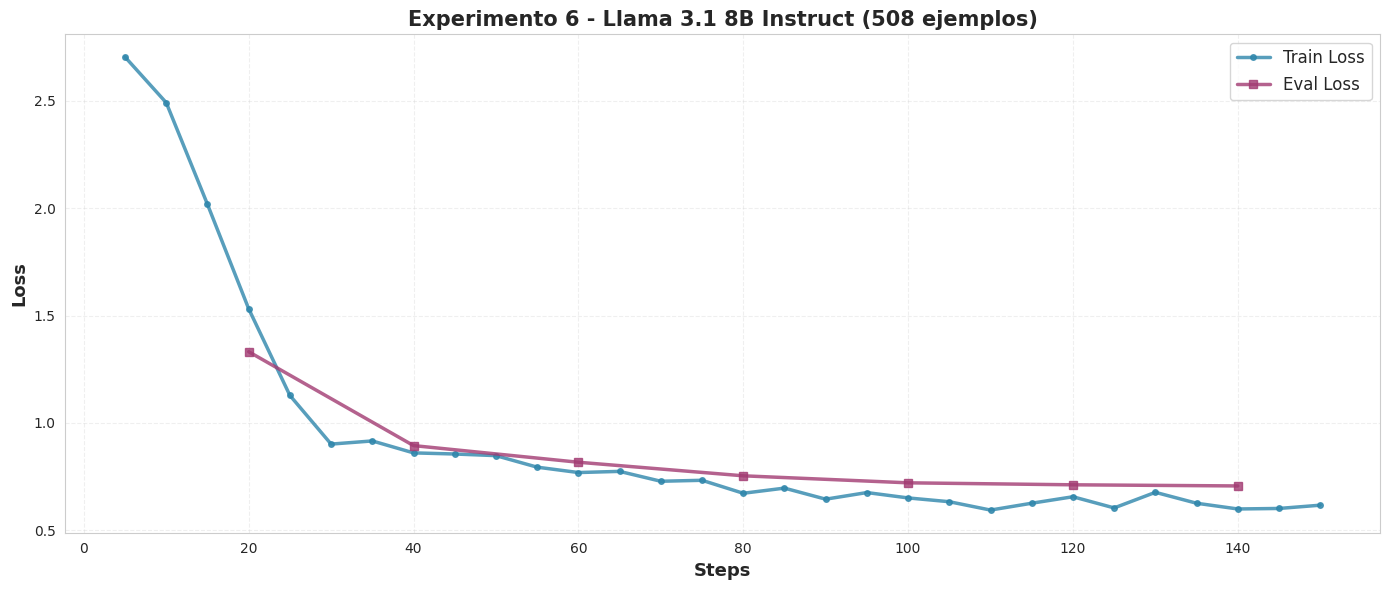

In [ ]:
trainer_llama.train()

callback_llama.plot_metrics()

In [ ]:
# Guardar
model_llama.save_pretrained("./model_llama")
tokenizer_llama.save_pretrained("./model_llama")

('./model_llama/tokenizer_config.json',
 './model_llama/special_tokens_map.json',
 './model_llama/chat_template.jinja',
 './model_llama/tokenizer.json')

### **LLAMA 3.1** METRICAS DE EVALUACIÓN

In [ ]:
print("RESUMEN EXPERIMENTO 6 - LLAMA 3.1 8B")
print("=" * 80)
if callback_llama.train_losses:
    print(f"Loss inicial: {callback_llama.train_losses[0]:.4f}")
    print(f"Loss final (train): {callback_llama.train_losses[-1]:.4f}")
    reduction = (callback_llama.train_losses[0] - callback_llama.train_losses[-1]) / callback_llama.train_losses[0] * 100
    print(f"Reducción: {reduction:.1f}%")
if callback_llama.eval_losses:
    print(f"Loss final (eval): {callback_llama.eval_losses[-1]:.4f}")
    gap = abs(callback_llama.train_losses[-1] - callback_llama.eval_losses[-1])
    print(f"Gap train-eval: {gap:.4f}")

    if gap < 0.1:
        print("Excelente: Sin overfitting")
    elif gap < 0.2:
        print("Moderado: Leve overfitting")
    else:
        print("Alto: Posible overfitting")

RESUMEN EXPERIMENTO 6 - LLAMA 3.1 8B
Loss inicial: 2.7035
Loss final (train): 0.6171
Reducción: 77.2%
Loss final (eval): 0.7067
Gap train-eval: 0.0896
Excelente: Sin overfitting


In [ ]:
def generate_llama_clean(model, tokenizer, question, max_tokens=300):

    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{SYSTEM_PROMPT}.<|eot_id|><|start_header_id|>user<|end_header_id|>

{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""

    FastLanguageModel.for_inference(model)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        repetition_penalty=1.1,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    full_response = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extraer SOLO la respuesta del asistente (después del último assistant header)
    if "<|start_header_id|>assistant<|end_header_id|>" in full_response:
        parts = full_response.split("<|start_header_id|>assistant<|end_header_id|>")
        response = parts[-1].strip()
    else:
        response = full_response

    # Limpiar tokens residuales
    response = response.replace("<|eot_id|>", "").strip()
    response = response.replace("<|end_of_text|>", "").strip()

    # Remover cualquier header residual del prompt original
    lines = response.split('\n')
    clean_lines = []
    skip_next = False

    for line in lines:
        line_lower = line.lower().strip()
        # Saltar headers del sistema
        if any(header in line_lower for header in ['system', 'user', 'assistant', 'eres un asistente']):
            if line_lower in ['system', 'user', 'assistant']:
                skip_next = True
                continue
        if not skip_next:
            clean_lines.append(line)
        skip_next = False

    response = '\n'.join(clean_lines).strip()

    return response


In [ ]:
def evaluate_llama_model(model, tokenizer, eval_dataset, num_samples=50):
    bleu_metric = BLEU()
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    # Seleccionar muestras aleatorias
    indices = random.sample(range(len(eval_dataset)), min(num_samples, len(eval_dataset)))

    print(f"\nEvaluando en {len(indices)} muestras...")

    for idx in tqdm(indices):
        # Obtener ejemplo
        text = eval_dataset[idx]["text"]

        # Extraer pregunta y respuesta de referencia del formato Llama
        if "<|start_header_id|>user<|end_header_id|>" in text and "<|start_header_id|>assistant<|end_header_id|>" in text:
            user_part = text.split("<|start_header_id|>user<|end_header_id|>")[1].split("<|eot_id|>")[0].strip()
            reference = text.split("<|start_header_id|>assistant<|end_header_id|>")[1].split("<|eot_id|>")[0].strip()

            # Generar respuesta
            prediction = generate_llama_clean(model, tokenizer, user_part, max_tokens=256)

            # Calcular BLEU
            bleu_score = bleu_metric.sentence_score(prediction, [reference]).score
            bleu_scores.append(bleu_score)

            # Calcular ROUGE
            rouge_scores = rouge.score(reference, prediction)
            rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
            rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
            rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    # Calcular promedios
    results = {
        'bleu': np.mean(bleu_scores),
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores),
        'num_samples': len(indices)
    }

    return results

# Evaluar
print("\nIniciando evaluación cuantitativa...")

results_llama = evaluate_llama_model(model_llama, tokenizer_llama, eval_dataset_llama, num_samples=50)

print("\n" + "=" * 80)
print("RESULTADOS EXPERIMENTO 6 - LLAMA 3.1 8B")
print("=" * 80)
print(f"BLEU:    {results_llama['bleu']:.4f}")
print(f"ROUGE-1: {results_llama['rouge1']:.4f}")
print(f"ROUGE-2: {results_llama['rouge2']:.4f}")
print(f"ROUGE-L: {results_llama['rougeL']:.4f}")
print(f"Muestras evaluadas: {results_llama['num_samples']}")


Iniciando evaluación cuantitativa...

Evaluando en 50 muestras...


100%|██████████| 50/50 [02:43<00:00,  3.27s/it]


RESULTADOS EXPERIMENTO 6 - LLAMA 3.1 8B
BLEU:    3.2126
ROUGE-1: 0.2217
ROUGE-2: 0.0477
ROUGE-L: 0.1722
Muestras evaluadas: 50


### **LLAMA 3.1** VALIDACION CUALITATIVA

In [ ]:
print("=" * 80)
print("RE-EVALUACIÓN CON RESPUESTAS LIMPIAS")
print("=" * 80)

print("\n")
for i, question in enumerate(test_questions, 1):
    print(f"[{i}/{len(test_questions)}] PREGUNTA: {question}")
    print("-" * 80)
    response = generate_llama_clean(model_llama, tokenizer_llama, question)
    print(response)
    print("\n")

RE-EVALUACIÓN CON RESPUESTAS LIMPIAS


[1/7] PREGUNTA: ¿Cuáles son las variedades de café resistentes a la roya?
--------------------------------------------------------------------------------
Las variedades Castillo, Tabi, Caturra, Típica, Supremo y la mayoría de las nuevas variedades tienen resistencia natural o moderada a la roya.


[2/7] PREGUNTA: ¿Qué es la variedad Castillo?
--------------------------------------------------------------------------------
Es una variedad híbrida resistente a la Roya (CR-14) desarrollada por Cenicafé, que combina alta calidad, buena productividad y resistencia a enfermedades.


[3/7] PREGUNTA: ¿Cómo mejorar la productividad del café?
--------------------------------------------------------------------------------
Algunos factores clave son: variedades resistentes a roya y royuela, densidad adecuada (5.000-6.000 plantas/ha), nutrición óptima, sombrío controlado, prácticas agronómicas precisas, uso de fertilizantes orgánicos y correcto manejo de agu

# WEB GRADIO



In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
def generate_response(message, history, max_tokens=512, temperature=0.7, top_p=0.9):
  return generate_llama_clean(model_llama, tokenizer_llama, message)

In [ ]:
def create_interface():
    # Cargar el modelo al iniciar

    # Ejemplos de preguntas
    examples = [
        ["¿Cuáles son las variedades de café resistentes a la roya?"],
        ["¿Cuál es la productividad promedio de café en Colombia?"],
        ["¿Qué diferencias hay entre Cenicafé 1 y Castillo?"],
        ["¿Cuándo debo sembrar café en Antioquia?"],
        ["¿Cuáles son las 8 prácticas agronómicas fundamentales?"],
        ["¿Cuánto ahorra Colombia por usar variedades resistentes a roya?"]
    ]

    # Crear interfaz de chat
    demo = gr.ChatInterface(
        fn=generate_response,
        title="☕ Chatbot de Café Colombiano",
        description="""
        **Asistente experto en café colombiano** entrenado con información de Cenicafé.

        Pregúntame sobre:
        - Variedades de café resistentes a la roya
        - Prácticas agronómicas
        - Productividad y economía cafetera
        - Épocas de siembra por región
        - Manejo de enfermedades

        **Modelo:** unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit (Experimento 6)
        """,
        examples=examples
    )

    return demo

In [ ]:
demo = create_interface()

print("\nLanzando aplicación...")
demo.launch(
    server_name="0.0.0.0",  # Permite acceso desde cualquier IP
    server_port=7864,        # Puerto por defecto de Gradio, cambiado a 7861
    share=False,             # Cambia a True para obtener un link público temporal
    show_error=True
)

/usr/local/lib/python3.12/dist-packages/gradio/chat_interface.py:347: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(



Lanzando aplicación...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# ANÁLISIS COMPARATIVO

#### DeepSeek R1-Distill-Qwen-1.5B-Multilingual (Experimentos 1, 2, 3)

Los tres experimentos con DeepSeek (modelo de 1.5B) demostraron tener mejores metricas cuantitativas, especialmente el experimento 3. En cuanto a lo cualitativo, de los tres el tercero tambien fue mejor, pero tiene tiene problemas graves que tiene que ver con la confusion de idiomas, siento que te alguna manera se esta aprendiendo los datos, no siento que este logrando generalizar, ademas esta alucinando en las respuestas.

DeepSeek Exp 3 (Mejor Cuantitativo): Este experimento tuvo la menor Validation Loss (0.739535) y las métricas BLEU y ROUGE-L más altas (0.3340 y 0.2599 respectivamente). Esto se logró aumentando las épocas a 5 y el tamaño de lote efectivo a 8 (Batch Size 4 x Acumulación 2). Sin embargo, el análisis cualitativo demostró un overfitting significativo, con respuestas incompletas y fuertes patrones de repetición.

DeepSeek Exp 2 (Rank Alto + LR Bajo): El aumento del rango LoRA a 32 y la disminución del Learning Rate a 1e-4 resultaron en el peor rendimiento de los modelos DeepSeek, con la Validation Loss más alta (0.991028). Cualitativamente, este modelo mostró una falta de coherencia y "alucinaciones" mezclando texto en inglés y caracteres chinos al intentar describir el control de la broca.

DeepSeek Exp 1 (Base): Sirvió como una línea base decente, pero también presentó la tendencia a la repetición infinita y la generación de contenido incoherente y alucinaciones.

#### Llama 3.1 8B Instruct (Experimento Llama)

Debido a que con los modelos de DeepSeek se obtuvieron resultados realmente decepcionantes se opto por utilizar un modelo significativamente más grande, con un Learning Rate mucho más bajo (5e-5) y se obtuvo lo siguiente:

Rendimiento Cuantitativo: A pesar de ser un modelo más grande, obtuvo métricas BLEU (0.2354) y ROUGE-L (0.1787) más bajas que el mejor modelo DeepSeek (Exp 3). Su Validation Loss (0.772520) fue el segundo mejor después del DeepSeek Exp 3.

Rendimiento Cualitativo (Superior): El modelo Llama 3.1 fue el claro ganador en la evaluación cualitativa, puesto que generó respuestas más naturales, estructuradas y con el tono de un asistente experto. fue menos propenso a los patrones de repetición y alucinaciones, para preguntas clave (ej. control de la broca), proporcionó respuestas correctas, concisas y limpias, demostrando una mejor capacidad de generalización y comprensión del contexto sin memorizar estructuras.

# CONCLUSIONES

- La evaluación reveló una tendencia clara, los modelos DeepSeek (Exp 1, 2, 3) muestran un overfitting al pequeño dataset de entrenamiento, resultando en métricas cuantitativas infladas (baja pérdida y alto ROUGE/BLEU) pero una pésima calidad de respuesta en la práctica (incoherencia, repetición y alucinaciones).

- El modelo Llama 3.1 8B (Exp 6), a pesar de tener métricas cuantitativas inferiores, demostró una calidad de respuesta significativamente mejor en pruebas cualitativas. Sus respuestas fueron más coherentes, relevantes y menos propensas a alucinaciones.

- Esto sugiere que para datasets pequeños y específicos, la evaluación cuantitativa tradicional puede no reflejar adecuadamente la calidad real del modelo. Es crucial complementar estas métricas con evaluaciones cualitativas para obtener una visión completa del desempeño del modelo.

- Sería interesante poder entrenar un modelo diferente con menos parametros parametros para obtener menores costos en uso de GPU en la app desplegada y a su vez conseguir mejor rendimiento

#